In [99]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary
import math
from tqdm import tqdm # <- para graficar la barra de avance


In [95]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [56]:
# primero creamos el dataset
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()#,#<---------------- esto es GLORIOSO!!
                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()#, #<------------------- esto es GLORIOSO!!
                        #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

In [57]:
print(type(dataloader))
print(type(dataloader['train']))
print(len(dataloader['train'].dataset))
print(len(dataloader['test'].dataset))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>
60000
10000


In [210]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=9, p=2, s=1, pk=9, ps=1, pp=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [217]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 16)
    self.conv1_out = None
    self.conv2 = conv_block(16, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 16)
    self.conv3_out = None
    # self.conv4 = conv_block(128, 128)
    # self.conv4_out = None
    self.fc = torch.nn.Linear(256, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    #self.sm = torch.nn.Softmax(dim=1)
    
    
    print('Red creada')
    print('arquitectura:')
    print(self)
    
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def n_layers(self):
    i=0
    for layer in self.children():
        i=i+1

    return i

  def n_parameters(self):
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    return pytorch_total_params

  def validar_dim(self, tam):
    print("Validacion de dimensiones")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    # x = self.conv4(x)
    # print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [101]:
def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        
        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        
        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))
        
    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

In [102]:
def validation(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    train_acc = []

    bar = tqdm(dataloader['test'])
    for batch in bar:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        train_acc.append(acc)
        bar.set_description(f"acc {np.mean(train_acc):.5f}")
        
    v_acc  = np.mean(train_acc)

    print(f"Accuracy {np.mean(v_acc):.5f}")
    plt.figure()
    plt.plot(train_acc, 'r')
    
    plt.title('acc')
    plt.legend(['train_acc', 'val loss'])
    plt.grid()

    return v_acc

In [214]:
def score(n_parameter, test_acc, n_layers):
    print(f"score is {n_layers * (1 / (math.log10(n_parameter)))} * accuracy")
    return test_acc * n_layers * (1 / (math.log10(n_parameter)))

In [218]:
model = CNN()
model.validar_dim(28)

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=9, stride=1, padding=2, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=9, stride=1, padding=2, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=9, stride=1, padding=2, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  4
Número total de parámetros a entrenar:  45386
Validacion de dimensiones
Tamaño entrada:  torch.Size([1, 1, 28, 28])
Tamaño salida conv1:  torch.Size([1, 16, 20, 20])
Tamaño salida conv2:  torch.Size([1, 16, 12, 12])
Tamaño salida conv3:  to

val_loss 0.18209 val_acc 0.95362: 100%|██████████| 157/157 [00:06<00:00, 25.56it/s]


Epoch 1/1 loss 0.71758 val_loss 0.18209 acc 0.79991 val_acc 0.95362


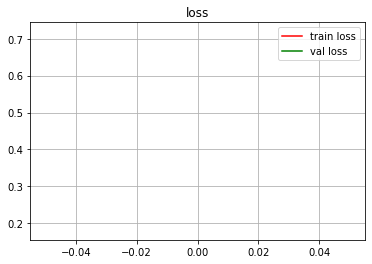

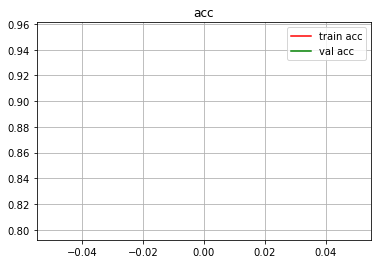

acc 0.95362: 100%|██████████| 157/157 [00:06<00:00, 25.05it/s]


Accuracy 0.95362
score is 0.8589364559550261 * accuracy
Score 0.81910


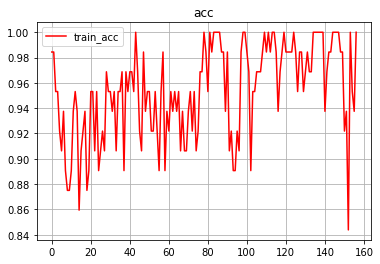

In [219]:
fit(model, dataloader, epochs=1)
accuracy = validation(model, dataloader)

s = score(model.n_parameters(), accuracy, model.n_layers())

print(f"Score {s:.5f}")


torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)
tensor(0.)


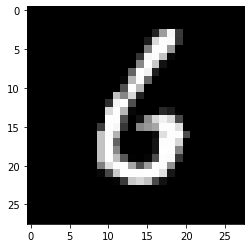

Tamaño imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[ 2.3817, -4.2330, -0.3555, -1.4387, -0.3231,  2.4547, 10.8524, -5.4744,
         -0.6243, -7.2804]])

softmax de predicción:
tensor([[2.0942e-04, 2.8075e-07, 1.3561e-05, 4.5902e-06, 1.4007e-05, 2.2528e-04,
         9.9952e-01, 8.1127e-08, 1.0364e-05, 1.3331e-08]])

El numero es un:  6


In [87]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 50

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))

# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print('Tamaño imagen de entrada a red: ', samp_img.shape)

# la paso al modelo
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())